## Описание задачи

В рамках Мастерской предлагаем поработать с данными о продажах автомобилей на вторичном рынке. Целью вашего проекта будет разработанная модель предсказания стоимости автомобиля на вторичном рынке.

### Данные

- train.csv - информация о продажах (~440000) автомобилей с аукционов, которые будут использоваться в качестве обучающих данных.
- test.csv - информация о продажах (~110000) автомобилей с аукционов, которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение 'sellingprice' для каждого автомобиля из этого датасета.
- sample_submission.csv - файл предсказаний в правильном формате.
- vin - идентификатор каждого автомобиля в тестовом наборе.
- sellingprice - Целевой признак. Для каждого автомобиля предскажите числовое значение стоимости автомобиля.

In [82]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/used-cars-price-prediction-yap17/sample_submission.csv
/kaggle/input/used-cars-price-prediction-yap17/train.csv
/kaggle/input/used-cars-price-prediction-yap17/test.csv


In [83]:
import matplotlib.pyplot as plt  
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.inspection import permutation_importance

In [84]:
df_train = pd.read_csv('/kaggle/input/used-cars-price-prediction-yap17/train.csv')
df_train.head(10)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)
5,2013,Lincoln,MKZ,Base,Sedan,automatic,3ln6l2j91dr817800,mi,2.5,14894.0,black,black,"ford motor credit company,llc",22600,Thu May 21 2015 02:00:00 GMT-0700 (PDT)
6,2010,pontiac,g6,4c,NaN,automatic,1g2za5eb4a4157380,nc,3.4,114587.0,silver,black,north state acceptance,5900,Mon Jan 12 2015 09:30:00 GMT-0800 (PST)
7,2013,Ford,Escape,SE,SUV,automatic,1fmcu0gx3duc59421,fl,4.8,26273.0,blue,gray,fields bmw,15200,Tue Feb 03 2015 01:00:00 GMT-0800 (PST)
8,2000,Hyundai,Elantra,GLS,Sedan,automatic,kmhjf35f2yu955691,oh,1.9,182624.0,black,tan,dt inventory,700,Thu Jan 22 2015 01:00:00 GMT-0800 (PST)
9,2005,Ford,Freestyle,Limited,wagon,automatic,1fmdk06135ga45438,oh,1.0,149364.0,black,tan,wells fargo dealer services,325,Tue Jun 16 2015 05:00:00 GMT-0700 (PDT)


In [85]:
df_test = pd.read_csv('/kaggle/input/used-cars-price-prediction-yap17/test.csv')
df_test.head(10)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST)
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST)
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,Fri Mar 06 2015 02:00:00 GMT-0800 (PST)
4,2013,Nissan,Titan,SV,Crew Cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,Wed Jun 03 2015 03:30:00 GMT-0700 (PDT)
5,2003,Volkswagen,Passat,GLS 1.8T,wagon,automatic,wvwvd63b93e175638,nc,2.4,104155.0,silver,black,fred anderson nissan of fayetteville,Tue Jun 09 2015 03:00:00 GMT-0700 (PDT)
6,2013,Hyundai,Sonata,GLS,Sedan,automatic,5npeb4ac4dh809686,il,3.7,30669.0,silver,gray,merchants leasing,Tue Mar 03 2015 02:00:00 GMT-0800 (PST)
7,2013,Ford,Explorer,Base,SUV,automatic,1fm5k7b97dgb16454,nc,3.2,87862.0,black,gray,ge fleet services for itself/servicer,Tue Feb 10 2015 01:15:00 GMT-0800 (PST)
8,2011,Infiniti,G Sedan,G37x,G Sedan,automatic,jn1cv6ar5bm411441,tn,3.5,47028.0,black,beige,nissan infiniti lt,Wed Feb 04 2015 02:30:00 GMT-0800 (PST)
9,2007,Chevrolet,Suburban,1500 LS,SUV,automatic,3gnfc16j77g158033,ga,3.4,191211.0,black,tan,riverside chevrolet inc,Tue Feb 10 2015 04:30:00 GMT-0800 (PST)


In [86]:
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110060 entries, 0 to 110059

# Предобработка данных

**Пропуски**

In [87]:
df_train.isna().sum()

year                0
make             8043
model            8123
trim             8337
body            10393
transmission    51461
vin                 0
state               0
condition        9405
odometer           69
color             586
interior          586
seller              0
sellingprice        0
saledate            0
dtype: int64

In [88]:
df_test.isna().sum()

year                0
make             2061
model            2079
trim             2114
body             2594
transmission    13012
vin                 0
state               0
condition        2379
odometer           19
color             158
interior          158
seller              0
saledate            0
dtype: int64

Предположу, что модель автомобиля очень важна в ходе исследования, не имеет смысла анализировать гипотетическую машину, поэтому пропуски в этой графе лучше удалить. Производитель жестко связан с моделью, например, модель Murano может быть только Nissan. Пропуски в модификации, типе кузова, типе КПП попробую заменить на значение other. Пропуски в цвете машины и цвете салона заменю на "-". А вот такие признаки, как состояние и пробег должны значительно влиять на результаты, поэтому пропуски в этих данных придется удалить.

In [89]:
# количество пропусков (понадобится далее)
first_none_model = df_train['model'].isna().sum() 
first_none_condition = df_train['condition'].isna().sum() 
first_none_odometer = df_train['odometer'].isna().sum() 
print(first_none_model, first_none_condition, first_none_odometer)

8123 9405 69


In [90]:
df_train.isna().mean() #посмотрим долю пропусков

year            0.000000
make            0.018270
model           0.018451
trim            0.018938
body            0.023608
transmission    0.116894
vin             0.000000
state           0.000000
condition       0.021364
odometer        0.000157
color           0.001331
interior        0.001331
seller          0.000000
sellingprice    0.000000
saledate        0.000000
dtype: float64

In [91]:
df_test.isna().mean()

year            0.000000
make            0.018726
model           0.018890
trim            0.019208
body            0.023569
transmission    0.118226
vin             0.000000
state           0.000000
condition       0.021615
odometer        0.000173
color           0.001436
interior        0.001436
seller          0.000000
saledate        0.000000
dtype: float64

Доля с пропусками для столбцов 'model', 'condition', 'odometer' не большая, поэтому можно удалить строки и пропусками в этих данных

In [92]:
df_train = df_train.dropna(subset=['model', 'condition', 'odometer' ])
df_test = df_test.dropna(subset=['model', 'condition', 'odometer' ])

In [93]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105621 entries, 0 to 110059
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          105621 non-null  int64  
 1   make          105621 non-null  object 
 2   model         105621 non-null  object 
 3   trim          105583 non-null  object 
 4   body          105180 non-null  object 
 5   transmission  93320 non-null   object 
 6   vin           105621 non-null  object 
 7   state         105621 non-null  object 
 8   condition     105621 non-null  float64
 9   odometer      105621 non-null  float64
 10  color         105482 non-null  object 
 11  interior      105482 non-null  object 
 12  seller        105621 non-null  object 
 13  saledate      105621 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 12.1+ MB


In [94]:
#заполним пропуски
to_fill_other = ['trim', 'body', 'transmission']
df_train[to_fill_other] = df_train[to_fill_other].fillna('other')

to_fill_dash = ['color', 'interior']
df_train[to_fill_dash] = df_train[to_fill_dash].fillna('—')

In [95]:
to_fill_other = ['trim', 'body', 'transmission']
df_test[to_fill_other] = df_test[to_fill_other].fillna('other')

to_fill_dash = ['color', 'interior']
df_test[to_fill_dash] = df_test[to_fill_dash].fillna('—')

In [96]:
df_train.isna().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
sellingprice    0
saledate        0
dtype: int64

In [97]:
df_test.isna().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
saledate        0
dtype: int64

Дубликаты

In [98]:
print(df_train.duplicated().sum())
print(df_test.duplicated().sum())

0
0


In [99]:
df_train.nunique() #число уникальных значений

year                30
make                91
model              944
trim              1875
body                86
transmission         3
vin             422755
state               38
condition           41
odometer        154484
color               20
interior            17
seller           11636
sellingprice      1710
saledate          3544
dtype: int64

In [100]:
for value in [df_train, df_test]: # посмотрим есть ли ошибки в значениях
    for column in ['year', 'make', 
       'body', 'transmission',
       'state', 'condition', 'color', 'interior']:        
        print('\033[1m' + f'Количество уникальных значений {column}:'+ '\033[0m', value[column].nunique())
        print(sorted(value[column].unique()))
        print()

Количество уникальных значений year: 30
[1984, 1985, 1986, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]

Количество уникальных значений make: 91
['Acura', 'Aston Martin', 'Audi', 'BMW', 'Bentley', 'Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Daewoo', 'Dodge', 'FIAT', 'Ferrari', 'Fisker', 'Ford', 'GMC', 'Geo', 'HUMMER', 'Honda', 'Hyundai', 'Infiniti', 'Isuzu', 'Jaguar', 'Jeep', 'Kia', 'Lamborghini', 'Land Rover', 'Lexus', 'Lincoln', 'MINI', 'Maserati', 'Mazda', 'Mercedes-Benz', 'Mercury', 'Mitsubishi', 'Nissan', 'Oldsmobile', 'Plymouth', 'Pontiac', 'Porsche', 'Ram', 'Rolls-Royce', 'Saab', 'Saturn', 'Scion', 'Subaru', 'Suzuki', 'Tesla', 'Toyota', 'Volkswagen', 'Volvo', 'acura', 'airstream', 'audi', 'bmw', 'buick', 'cadillac', 'chevrolet', 'chrysler', 'dodge', 'dodge tk', 'dot', 'ford', 'ford truck', 'gmc', 'gmc truck', 'honda', 'hyundai', 'jeep', 'kia', 'land rover', 'la

Обнаружены неявные дубликаты. Поработаем с ними

In [101]:
#Приведм данные к одинаковому строковому формату - первая заглавная
df_train['make'] = df_train['make'].str.title()
df_train['body'] = df_train['body'].str.title()
df_test['make'] = df_test['make'].str.title()
df_test['body'] = df_test['body'].str.title()

In [102]:
for value in [df_train, df_test]: 
    for column in ['make', 'body']:  
        print('\033[1m' + f'Количество уникальных значений {column}:'+ '\033[0m', value[column].nunique())
        print(sorted(value[column].unique()))
        print()

Количество уникальных значений make: 61
['Acura', 'Airstream', 'Aston Martin', 'Audi', 'Bentley', 'Bmw', 'Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Daewoo', 'Dodge', 'Dodge Tk', 'Dot', 'Ferrari', 'Fiat', 'Fisker', 'Ford', 'Ford Truck', 'Geo', 'Gmc', 'Gmc Truck', 'Honda', 'Hummer', 'Hyundai', 'Infiniti', 'Isuzu', 'Jaguar', 'Jeep', 'Kia', 'Lamborghini', 'Land Rover', 'Landrover', 'Lexus', 'Lincoln', 'Maserati', 'Mazda', 'Mercedes', 'Mercedes-B', 'Mercedes-Benz', 'Mercury', 'Mini', 'Mitsubishi', 'Nissan', 'Oldsmobile', 'Plymouth', 'Pontiac', 'Porsche', 'Ram', 'Rolls-Royce', 'Saab', 'Saturn', 'Scion', 'Smart', 'Subaru', 'Suzuki', 'Tesla', 'Toyota', 'Volkswagen', 'Volvo', 'Vw']

Количество уникальных значений body: 46
['Access Cab', 'Beetle Convertible', 'Cab Plus', 'Cab Plus 4', 'Club Cab', 'Convertible', 'Coupe', 'Crew Cab', 'Crewmax Cab', 'Cts Coupe', 'Cts Wagon', 'Cts-V Coupe', 'Cts-V Wagon', 'Double Cab', 'E-Series Van', 'Elantra Coupe', 'Extended Cab', 'G Convertible', 'G Coupe', 

In [103]:
#заменим некоторые неявные дубликаты
def replace_make_values(df):
    replacements = {
        'Dodge Tk': 'Dodge',
        'Mercedes-B': 'Mercedes',
        'Mercedes-Benz': 'Mercedes',
        'Gmc Truck': 'Gmc',
        'Ford Tk': 'Ford',
        'Hyundai Tk': 'Hyundai',
        'Mercedes-Benz': 'Mercedes',
        'Vw': 'Volkswagen'
    }   
    for old_value, new_value in replacements.items():
        df['make'] = df['make'].replace(old_value, new_value)
    return df

In [104]:
# используем функцию
df_train = replace_make_values(df_train)
df_test = replace_make_values(df_test)

In [105]:
def replace_body_types(df, column='body'):
    def replace_if_contains(word, text):
        if word.lower() in text.lower():
            return word
        else:
            return text
    
    df[column] = df[column].apply(lambda x: replace_if_contains("Coupe", x))
    df[column] = df[column].apply(lambda x: replace_if_contains("Sedan", x))
    df[column] = df[column].apply(lambda x: replace_if_contains("Wagon", x))
    df[column] = df[column].apply(lambda x: replace_if_contains("Convertible", x))
    df[column] = df[column].apply(lambda x: replace_if_contains("Van", x))
    df[column] = df[column].apply(lambda x: replace_if_contains("Cab", x))
    return df

In [106]:
# используем функцию
df_train = replace_body_types(df_train)
df_test = replace_body_types(df_test)

In [107]:
for value in [df_train, df_test]: 
    for column in ['make', 'body']:  
        print('\033[1m' + f'Количество уникальных значений {column}:'+ '\033[0m', value[column].nunique())
        print(sorted(value[column].unique()))
        print()

Количество уникальных значений make: 56
['Acura', 'Airstream', 'Aston Martin', 'Audi', 'Bentley', 'Bmw', 'Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Daewoo', 'Dodge', 'Dot', 'Ferrari', 'Fiat', 'Fisker', 'Ford', 'Ford Truck', 'Geo', 'Gmc', 'Honda', 'Hummer', 'Hyundai', 'Infiniti', 'Isuzu', 'Jaguar', 'Jeep', 'Kia', 'Lamborghini', 'Land Rover', 'Landrover', 'Lexus', 'Lincoln', 'Maserati', 'Mazda', 'Mercedes', 'Mercury', 'Mini', 'Mitsubishi', 'Nissan', 'Oldsmobile', 'Plymouth', 'Pontiac', 'Porsche', 'Ram', 'Rolls-Royce', 'Saab', 'Saturn', 'Scion', 'Smart', 'Subaru', 'Suzuki', 'Tesla', 'Toyota', 'Volkswagen', 'Volvo']

Количество уникальных значений body: 11
['Cab', 'Convertible', 'Coupe', 'Hatchback', 'Koup', 'Other', 'Sedan', 'Supercrew', 'Suv', 'Van', 'Wagon']

Количество уникальных значений make: 53
['Acura', 'Aston Martin', 'Audi', 'Bentley', 'Bmw', 'Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Daewoo', 'Dodge', 'Ferrari', 'Fiat', 'Fisker', 'Ford', 'Geo', 'Gmc', 'Honda', 'Hummer', 

In [108]:
for value in [df_train, df_test]: # посмотрим есть ли ошибки в значениях
    for column in ['color', 'interior']:        
        print('\033[1m' + f'Количество уникальных значений {column}:'+ '\033[0m', value[column].nunique())
        print(sorted(value[column].unique()))
        print()

Количество уникальных значений color: 20
['beige', 'black', 'blue', 'brown', 'burgundy', 'charcoal', 'gold', 'gray', 'green', 'lime', 'off-white', 'orange', 'pink', 'purple', 'red', 'silver', 'turquoise', 'white', 'yellow', '—']

Количество уникальных значений interior: 17
['beige', 'black', 'blue', 'brown', 'burgundy', 'gold', 'gray', 'green', 'off-white', 'orange', 'purple', 'red', 'silver', 'tan', 'white', 'yellow', '—']

Количество уникальных значений color: 20
['beige', 'black', 'blue', 'brown', 'burgundy', 'charcoal', 'gold', 'gray', 'green', 'lime', 'off-white', 'orange', 'pink', 'purple', 'red', 'silver', 'turquoise', 'white', 'yellow', '—']

Количество уникальных значений interior: 17
['beige', 'black', 'blue', 'brown', 'burgundy', 'gold', 'gray', 'green', 'off-white', 'orange', 'purple', 'red', 'silver', 'tan', 'white', 'yellow', '—']



**Изменение типов данных**


Поменяю на целочисленный формат значения в графе 'odometer'

In [109]:
df_train['odometer'] = df_train[df_train['odometer'].notnull()]['odometer'].astype('int') #переведем формат float на int
df_test['odometer'] = df_test[df_test['odometer'].notnull()]['odometer'].astype('int') 

In [110]:
df_train.head(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,Suv,automatic,2fmdk3jc4bba41556,md,4.2,111041,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,Sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)


Мне кажется некорректным тип данных в столбце "дата продажи". 

In [111]:
#заменим на формат даты
df_train['saledate'] = pd.to_datetime(df_train['saledate'], utc=True)
df_test['saledate'] = pd.to_datetime(df_test['saledate'], utc=True)
df_train.head(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,Suv,automatic,2fmdk3jc4bba41556,md,4.2,111041,black,black,santander consumer,12500,2015-06-01 19:30:00+00:00
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034,black,black,ars/avis budget group,14500,2015-02-24 18:00:00+00:00
2,2012,Nissan,Sentra,2.0 SL,Sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619,black,black,nissan-infiniti lt,9100,2015-06-09 19:30:00+00:00


In [112]:
#выделим год
df_train['time_rounded'] = df_train['saledate'].dt.year
df_test['time_rounded'] = df_test['saledate'].dt.year
df_train.head(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,time_rounded
0,2011,Ford,Edge,SEL,Suv,automatic,2fmdk3jc4bba41556,md,4.2,111041,black,black,santander consumer,12500,2015-06-01 19:30:00+00:00,2015
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034,black,black,ars/avis budget group,14500,2015-02-24 18:00:00+00:00,2015
2,2012,Nissan,Sentra,2.0 SL,Sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619,black,black,nissan-infiniti lt,9100,2015-06-09 19:30:00+00:00,2015


In [113]:
#посчитаем возраст машины
df_train['car_age'] = df_train['time_rounded'] - df_train['year']
df_test['car_age'] = df_test['time_rounded'] - df_test['year']
df_train.head(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,time_rounded,car_age
0,2011,Ford,Edge,SEL,Suv,automatic,2fmdk3jc4bba41556,md,4.2,111041,black,black,santander consumer,12500,2015-06-01 19:30:00+00:00,2015,4
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034,black,black,ars/avis budget group,14500,2015-02-24 18:00:00+00:00,2015,1
2,2012,Nissan,Sentra,2.0 SL,Sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619,black,black,nissan-infiniti lt,9100,2015-06-09 19:30:00+00:00,2015,3


**Вывод:**

Проведена обработка данных, обработаны пропуски, явные и неявные дубликаты, исправлены типы данных, добавлен новый признак.

# Исследовательский анализ данных

**Проверим корреляцию**

                  year  condition  odometer  sellingprice  time_rounded  \
year          1.000000   0.550697 -0.776659      0.579570      0.055666   
condition     0.550697   1.000000 -0.538087      0.536073      0.040578   
odometer     -0.776659  -0.538087  1.000000     -0.577108     -0.036089   
sellingprice  0.579570   0.536073 -0.577108      1.000000      0.036728   
time_rounded  0.055666   0.040578 -0.036089      0.036728      1.000000   
car_age      -0.997542  -0.548647  0.775251     -0.577832      0.014429   

               car_age  
year         -0.997542  
condition    -0.548647  
odometer      0.775251  
sellingprice -0.577832  
time_rounded  0.014429  
car_age       1.000000  


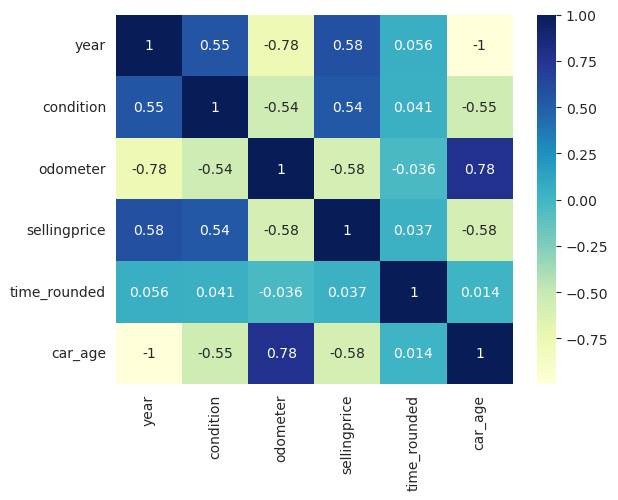

In [114]:
print(df_train.corr())   
df_plot = sns.heatmap(df_train.corr(), cmap="YlGnBu", annot=True)  
plt.show()

Числовые признаки кажутся важными, так как и прямая и обратная зависимость более 54%. Самая большая корреляция между возрастом машины и пробегом, что логично.

Целевой признак - sellingprice. Надо выяснить, как влияют на цену все основные параменты

**Возраст машины**

In [115]:
def plot_average_selling_price_by_indicator(df, indicator_column, price_column, name_indicator):
    """ Строит гистограмму средней цены продажи от различных показателей."""
    # Группируем данные, вычисляем среднее значение цены продажи, cтроим график
    df.groupby(indicator_column)[price_column].mean().plot(kind='bar', 
                                                           figsize=(10, 5), 
                                                           grid=True, 
                                                           title=f'Средняя цена продажи по {name_indicator}')
    # Устанавливаем подписи осей
    plt.xlabel(indicator_column)
    plt.ylabel(price_column)
    
    plt.show()

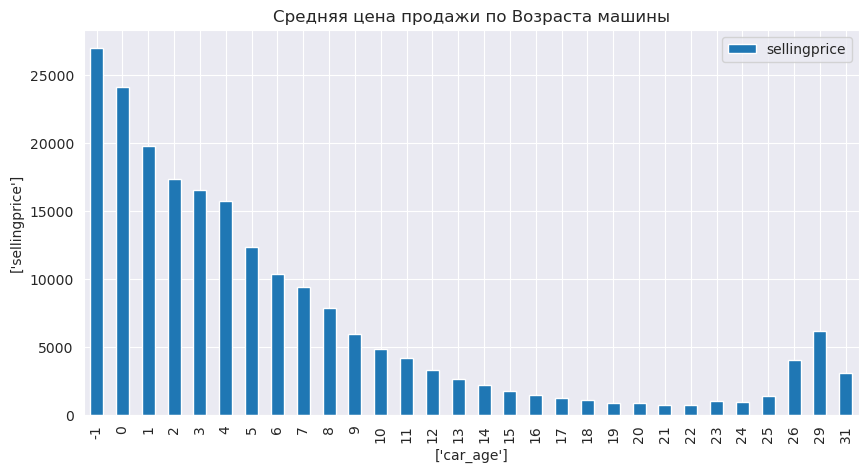

In [116]:
plot_average_selling_price_by_indicator(df_train, ['car_age'], ['sellingprice'], 'Возраста машины')

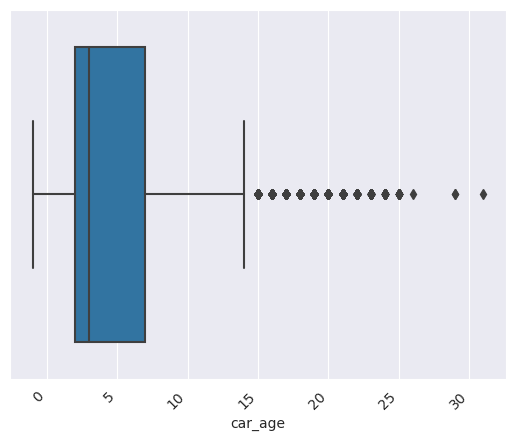

In [117]:
sns.boxplot(
    x='car_age', 
    data=df_train
)
plt.xticks(rotation=45, 
           ha='right');

Цена машины очень зависит от возраста машины. Чем моложе машина, тем цена выше. Программа расценила высокую цену на старые машины как выбросы. Однако, я не стала бы их удалять, так как, вероятно, эти машины уже относятся к раритетам и, поэтому, цены на их выше. 

**Производитель**

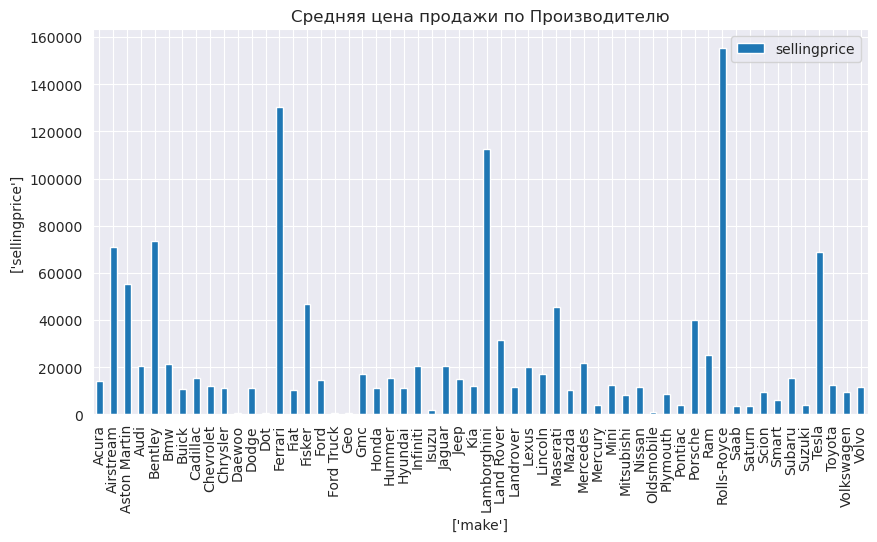

In [118]:
plot_average_selling_price_by_indicator(df_train, ['make'], ['sellingprice'], 'Производителю')

Конечно, от Производителя зависит цена продажи.

**Тип кузова**

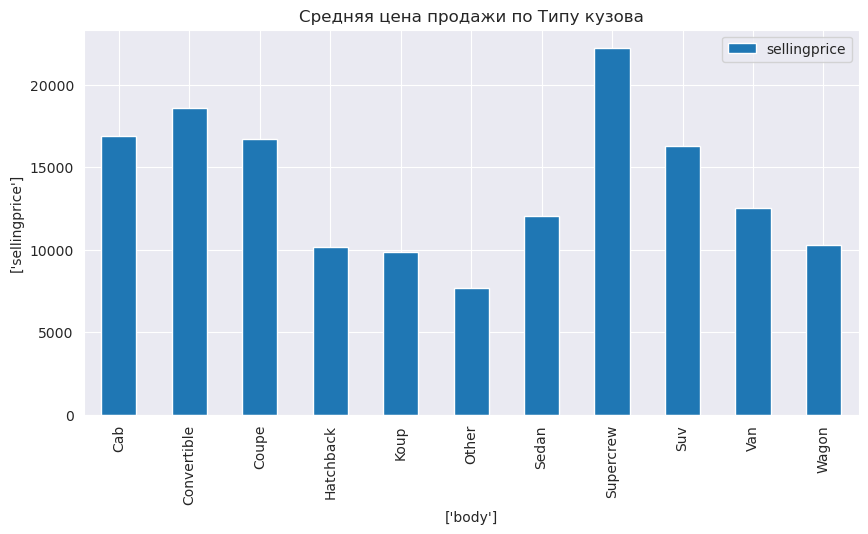

In [119]:
plot_average_selling_price_by_indicator(df_train, ['body'], ['sellingprice'], 'Типу кузова')

Самые дорогие машины в кузове Supercrew, Convertible

**Тип КПП**

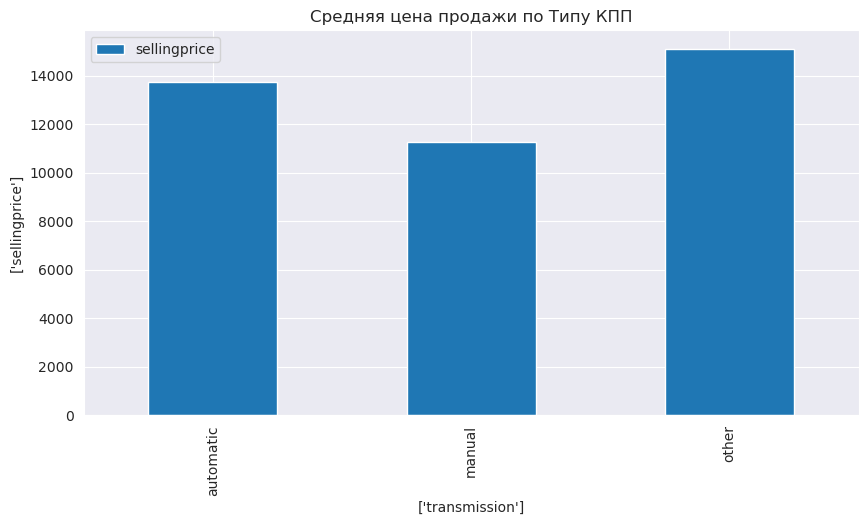

In [120]:
plot_average_selling_price_by_indicator(df_train, ['transmission'], ['sellingprice'], 'Типу КПП')

Машина с автоматической коробкой передач дороже, чем с ручной

**Штат регистрации**

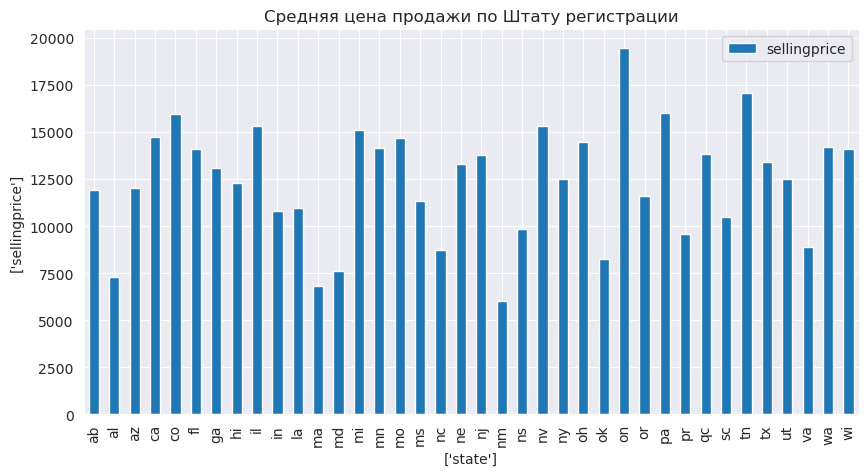

In [121]:
plot_average_selling_price_by_indicator(df_train, ['state'], ['sellingprice'], 'Штату регистрации')

**Состояние машины**

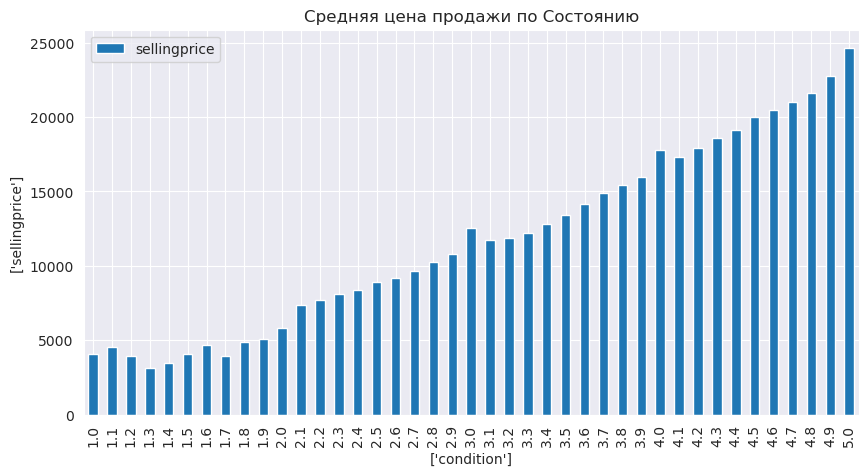

In [122]:
plot_average_selling_price_by_indicator(df_train, ['condition'], ['sellingprice'], 'Состоянию')

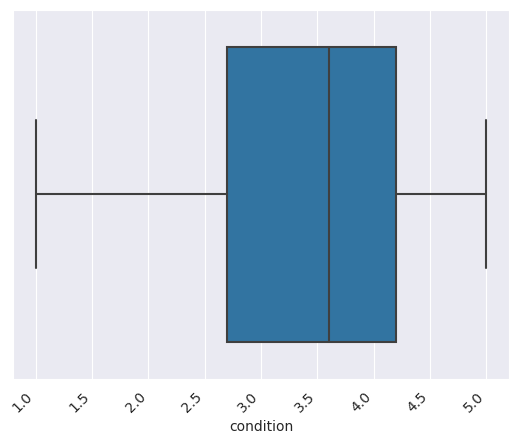

In [123]:
sns.boxplot(
    x='condition', 
    data=df_train
)
plt.xticks(rotation=45, 
           ha='right');

От состояния зависимость очень явная, выбросов нет

**Цвет кузова**

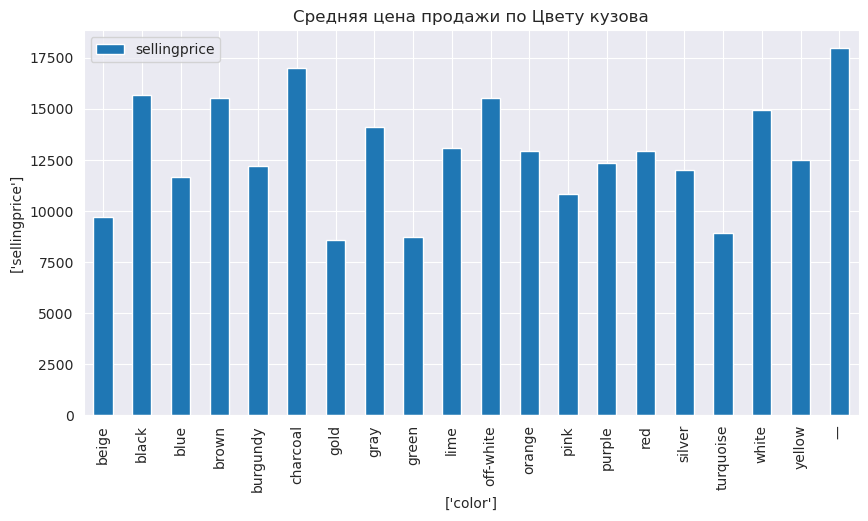

In [124]:
plot_average_selling_price_by_indicator(df_train, ['color'], ['sellingprice'], 'Цвету кузова')

**Цвет интерьера**

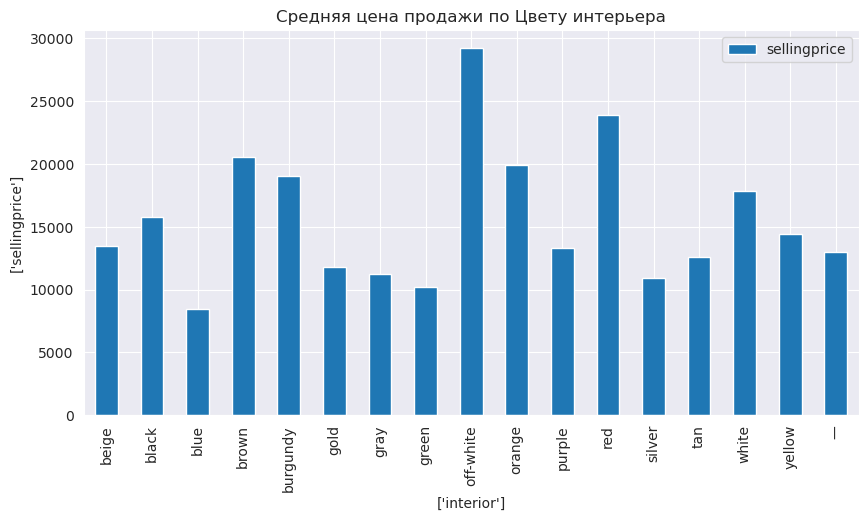

In [125]:
plot_average_selling_price_by_indicator(df_train, ['interior'], ['sellingprice'], 'Цвету интерьера')

**Пробег**

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  """


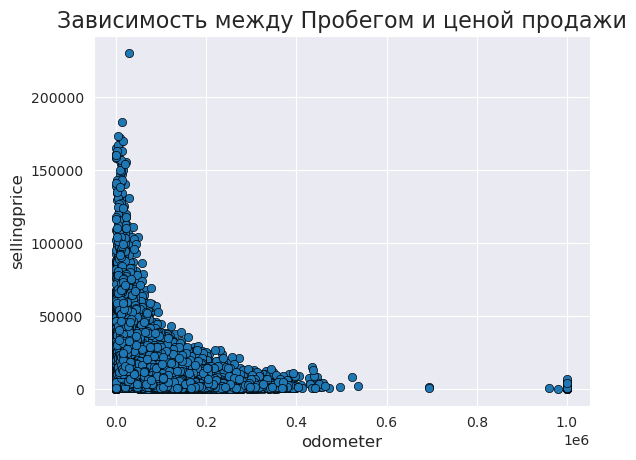

In [126]:
sns.set_style('darkgrid')
plt.title('Зависимость между Пробегом и ценой продажи',size=16)
plt.xlabel('odometer',size=12)
plt.ylabel('sellingprice',size=12)
sns.scatterplot(x='odometer', y='sellingprice', data=df_train, edgecolor='black', palette='cubehelix')
plt.show();

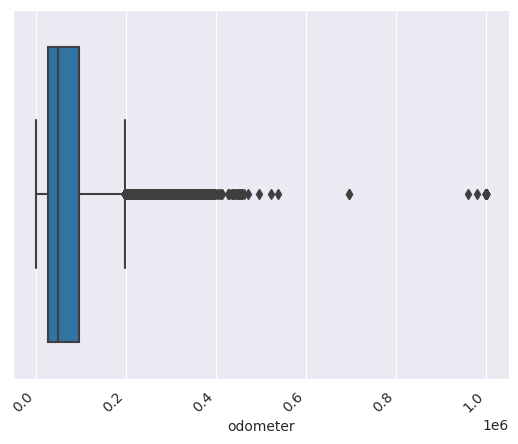

In [127]:
sns.boxplot(
    x='odometer', 
    data=df_train
)
plt.xticks(rotation=45, 
           ha='right');

In [128]:
df_train['odometer'].describe()

count    422755.000000
mean      66472.329103
std       52429.874299
min           1.000000
25%       27664.000000
50%       50182.000000
75%       96263.000000
max      999999.000000
Name: odometer, dtype: float64

Зависимость между параметрами явная, чем меньше пробег, тем выше цена прдажи. Обнаружены выбросы для машин с пробегом 700000 миль

In [129]:
df_train[df_train['odometer'] > 700000][['odometer']].count() #посмотрим сколько таких машин

odometer    54
dtype: int64

In [130]:
df_train[df_train['odometer'] > 700000] #посмотрим, что это за строки

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,time_rounded,car_age
6069,2012,Hyundai,Sonata,GLS,Sedan,automatic,5npeb4ac6ch429831,oh,1.0,999999,white,gray,santander consumer,800,2015-01-05 21:00:00+00:00,2015,3
11122,2004,Chevrolet,Tahoe,LS,Suv,automatic,1gnec13v34j247109,ga,1.9,999999,black,tan,santander consumer,1800,2015-01-05 17:30:00+00:00,2015,11
12368,2006,Mazda,Tribute,i,Suv,automatic,4f2yz02z26km30632,fl,2.0,999999,white,tan,santander consumer,1200,2015-02-08 17:30:00+00:00,2015,9
14897,2006,Kia,Amanti,Base,Sedan,automatic,knald124265085150,ms,1.0,999999,gray,beige,fiserv/global lending services,800,2014-12-18 04:02:00+00:00,2014,8
17341,1996,Toyota,Corolla,Base,Sedan,automatic,2t1ba02e0tc143572,fl,1.0,959276,blue,gray,coggin honda of ft pierce,500,2015-02-17 02:00:00+00:00,2015,19
26602,2005,Nissan,Quest,3.5 SE,Van,automatic,5n1bv28u15n131795,il,1.9,999999,green,gray,santander consumer,2600,2014-12-30 02:00:00+00:00,2014,9
45730,2001,Chevrolet,Silverado 1500,LS,Cab,automatic,1gcec19v81z169441,ca,1.0,999999,white,black,800 loan mart,1500,2015-05-27 22:00:00+00:00,2015,14
78696,2006,Nissan,Quest,3.5 SE,Van,automatic,5n1bv28u26n123304,md,2.7,999999,white,beige,santander consumer,2800,2015-02-23 17:30:00+00:00,2015,9
79958,2011,Nissan,Altima,2.5 S,Sedan,automatic,1n4al2ap1bn503809,ms,2.3,999999,blue,black,gm financial,4000,2015-05-13 22:02:00+00:00,2015,4
84696,2005,Nissan,Quest,3.5 SE,Van,automatic,5n1bv28u05n111490,md,2.1,999999,white,beige,355 toyota,1100,2015-01-13 01:30:00+00:00,2015,10


Это небольшое количество данных, можно удалить эти выбросы

In [131]:
df_train = df_train[df_train.odometer < 700000] # удалим эти выбросы
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 422701 entries, 0 to 440235
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   year          422701 non-null  int64              
 1   make          422701 non-null  object             
 2   model         422701 non-null  object             
 3   trim          422701 non-null  object             
 4   body          422701 non-null  object             
 5   transmission  422701 non-null  object             
 6   vin           422701 non-null  object             
 7   state         422701 non-null  object             
 8   condition     422701 non-null  float64            
 9   odometer      422701 non-null  int64              
 10  color         422701 non-null  object             
 11  interior      422701 non-null  object             
 12  seller        422701 non-null  object             
 13  sellingprice  422701 non-null  int64        

In [132]:
# итого мы удалили
deleted = first_none_model + first_none_condition + first_none_odometer + 54
print('Удалено, %:', deleted / 440236 * 100)

Удалено, %: 4.0094403910629755


Удалено 4% данных, что является допустимым.

**Вывод:**

В ходе исследовательского анализа выявлены следующе закономерности:

- Числовые признаки кажутся важными, так как и прямая и обратная зависимость более 54%. Самая большая корреляция между возрастом машины и пробегом.
- Цена машины очень зависит от возраста машины. Чем моложе машина, тем цена выше. Программа расценила высокую цену на старые машины как выбросы. Однако, это возможно, раритетные машины.
- от Производителя зависит цена продажи.
- Самые дорогие машины в кузове Supercrew, Convertible
- Машина с автоматической коробкой передач дороже, чем с ручной.
- От состояния машины зависит очень цена.
- Зависимость между параметрами явная, чем меньше пробег, тем выше цена прдажи.

Удалено 4% данных, что является допустимым.

## Подготовим данные для обучения

Выделим признаки для расчета

In [133]:
target_train = df_train['sellingprice'] #целевой признак
features_train = df_train.drop(['sellingprice'] , axis=1) #признаки, по которым идет расчет
print(features_train.shape)

(422701, 16)


In [134]:
features_test = df_test 
features_test.head(1)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate,time_rounded,car_age
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970,silver,black,lexus of stevens creek,2015-01-13 20:30:00+00:00,2015,10


Удалим лишние столбцы. 

- make жестко связан с model, поэтому можно этот признак удалить.
- year использован для расчета возраста машины
- vin не имеет несет никакой информации
- seller имеет много значений, предполагаю, что цена машины не связана с проадвцом
- saledate признако обработан, заменен на два других признака

In [135]:
features_train.drop(columns=['make', 'vin', 'seller', 'saledate', 'time_rounded', 'year'], inplace=True)
features_test.drop(columns=['make', 'seller', 'saledate', 'time_rounded', 'year'], inplace=True)

In [136]:
features_train.head(1)

,model,trim,body,transmission,state,condition,odometer,color,interior,car_age
0,Edge,SEL,Suv,automatic,md,4.2,111041,black,black,4


In [137]:
features_test.head(1)

,model,trim,body,transmission,vin,state,condition,odometer,color,interior,car_age
0,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970,silver,black,10


В тестовом файле оставим столбец vin, так как она понадобится для проверки далее.

#  Тестирование моделей

**Пайплайн**

In [138]:
categorical_columns = features_train.select_dtypes(include='object').columns.to_list()
numeric_columns = features_train.select_dtypes(exclude='object').columns.to_list()

col_transformer_ohe = make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_columns),
    (StandardScaler(), numeric_columns),
    remainder='passthrough', verbose_feature_names_out=False)

col_transformer_oe = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_columns),
    remainder='passthrough', verbose_feature_names_out=False)

**Модель Решающее дерево**

In [139]:
model_dt = DecisionTreeRegressor()
pipeline_dt = make_pipeline(col_transformer_oe, model_dt)
#sorted(pipeline_dt.get_params().keys())

In [140]:
%%time
params = {
    'decisiontreeregressor__max_leaf_nodes': [50, 100, 200],
    'decisiontreeregressor__max_depth': [4, 6, 10, 12],
    'decisiontreeregressor__random_state': [13]
}

grid_dt = GridSearchCV(pipeline_dt, param_grid=params, cv=5, scoring='neg_mean_squared_error').fit(features_train, target_train) 
grid_dt.best_params_

CPU times: user 2min 14s, sys: 2.51 s, total: 2min 17s
Wall time: 2min 17s


{'decisiontreeregressor__max_depth': 12,
 'decisiontreeregressor__max_leaf_nodes': 200,
 'decisiontreeregressor__random_state': 13}

In [142]:
rmse_dt = np.sqrt(np.abs(best_score_dt)).round(2)
predicted_dt = grid_dt.predict(features_train) 
r2_dt = r2_score(target_train, predicted_dt).round(2)
mae_dt = mean_absolute_error(target_train, predicted_dt).round(2)
print("RMSE:", rmse_dt)
print('R2:', r2_dt)
print('MAE:', mae_dt)

RMSE: 5225.72
R2: 0.72
MAE: 3215.12


**Модель Случайный лес**

In [143]:
model_rf = RandomForestRegressor()
pipeline_rf = Pipeline(steps=[
    ('transf', col_transformer_oe),
    ('model', model_rf)
])
#sorted(pipeline_rf.get_params().keys())

In [144]:
%%time
params_rf = {
    'model__n_estimators': [10, 20, 30],
    'model__max_depth': [4, 6, 10, 12],
    'model__random_state': [13]
}

grid_rf = GridSearchCV(pipeline_rf, param_grid=params_rf, cv=5, scoring='neg_mean_squared_error').fit(features_train, target_train) 
grid_rf.best_params_

CPU times: user 20min 55s, sys: 2.7 s, total: 20min 58s
Wall time: 21min 4s


{'model__max_depth': 12, 'model__n_estimators': 30, 'model__random_state': 13}

In [146]:
rmse_rf = np.sqrt(np.abs(best_score_rf)).round(2)
predicted_rf = grid_rf.predict(features_train) 
r2_rf = r2_score(target_train, predicted_rf).round(2)
mae_rf = mean_absolute_error(target_train, predicted_rf).round(2)
print("RMSE:", rmse_rf)
print('R2:', r2_rf)
print('MAE:', mae_rf)

RMSE: 4212.21
R2: 0.83
MAE: 2280.3


**Модель Линейная регрессия**

In [147]:
model_lr = LinearRegression()
pipeline_lr = make_pipeline(col_transformer_ohe, model_lr)
#sorted(pipeline_lr.get_params().keys())

In [148]:
%%time
params_lr = {
    'linearregression__fit_intercept':[True, False],
    'linearregression__copy_X':[True, False]
}

grid_lr = GridSearchCV(pipeline_lr, param_grid=params_lr, cv=5, scoring='neg_mean_squared_error').fit(features_train, target_train) 
grid_lr.best_params_

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown catego

CPU times: user 1h 35min 5s, sys: 1h 22min 27s, total: 2h 57min 32s
Wall time: 46min 31s


{'linearregression__copy_X': True, 'linearregression__fit_intercept': True}

In [149]:
rmse_lr = np.sqrt(np.abs(best_score_lr)).round(2)
predicted_lr = grid_lr.predict(features_train) 
r2_lr = r2_score(target_train, predicted_lr).round(2)
mae_lr = mean_absolute_error(target_train, predicted_lr).round(2)
print("RMSE:", rmse_lr)
print('R2:', r2_lr)
print('MAE:', mae_lr)

RMSE: 3302.76
R2: 0.89
MAE: 2056.55


In [150]:
tab_comp = pd.DataFrame(
    data=[('RMSE', rmse_dt, rmse_rf, rmse_lr), 
          ('R2', r2_dt, r2_rf, r2_lr),
          ('MAE', mae_dt, mae_rf, mae_lr)      
         ], 
    columns=['Метрики', 'Решающее дерево', 'Случайный лес', 'Линейная регрессия'])

tab_comp

,Метрики,Решающее дерево,Случайный лес,Линейная регрессия
0,RMSE,5225.72,4212.21,3302.76
1,R2,0.72,0.83,0.89
2,MAE,3215.12,2280.30,2056.55


Лучше всех себя показала модель линейной регрессии. По всем выбранным метрикам эта модель оказалась лучшей. Проверим ее на тестовой модели. 

# Проверка на тестовой модели (подготовка файла для загрузки)

In [151]:
predicted_best = grid_lr.predict(features_test)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  UserWarning,


In [152]:
df_test['sellingprice'] = predicted_best # добавим колонку sellingprice

In [153]:
df_test.head(5)

,model,trim,body,transmission,vin,state,condition,odometer,color,interior,car_age,sellingprice
0,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970,silver,black,10,4821.141180
1,Savana Cargo,2500,Van,other,1gtw7fca7e1902207,pa,4.4,6286,white,gray,1,21279.357761
2,Murano,S,Suv,automatic,jn8az1mw6dw303497,oh,4.6,11831,gray,black,2,20365.700205
3,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105,silver,black,2,9021.957315
4,Titan,SV,Cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083,black,black,2,20826.470816


In [154]:
test_prediction = df_test[['vin', 'sellingprice']]

In [155]:
test_prediction = test_prediction.query('vin != "4s2cm58v9s4375559" and vin != "1ftne2ew6eda13643"')

In [156]:
test_prediction.head()

,vin,sellingprice
0,1g6dp567450124779,4821.141180
1,1gtw7fca7e1902207,21279.357761
2,jn8az1mw6dw303497,20365.700205
3,2g1wf5e34d1160703,9021.957315
4,1n6aa0ec3dn301209,20826.470816


In [157]:
len(test_prediction)

105619

In [158]:
test_prediction.to_csv("test_prediction.csv", index=False) 

**Вывод:** 

В ходе работы были исследованы данные, влияющие на цену машины. Выявлены закономерности и проведено тестирование трех моделей на данных. Лучше всех себя показала модель линейной регрессии по всем выбранным метрикам.

Так как работа была выложена на Kaggle, я не имела возможности проверить сама работу модели на тестовой выборке. Метрика, которая была расчитана приложением Kaggle: MAPE = 54,18, что является не очень хорошим результатом. Могу предположить, что надо было больше обобщить данные о модели и виде кузова.